# SPATIAL ANALYSIS OF ISS DATASETS

This tutorial is an example of how to use Squidpy to analyze Xenium datasets, performing several different statistical tests to understand the spatial organization of tissues. This tutorial follows the scanpy tutorial/pciseq tutorials, so we'll take as an input an h5 object created. More information, if needed, can be found at: https://squidpy.readthedocs.io/en/stable/tutorials.html

# Loading the needed packages

The first step is to load the needed packages. If any of them fails, please go and check that they are installed in the appropiate environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import squidpy as sq
import scanpy as sc
import os

# Load your dataset

We are going to load our dataset, were we have alredy performed clustering, from an h5ad file. If you want to check how to format your data in this format, please check the Scanpy tutorial

In [2]:
saving_path=r'../../data/processed_adata/'
adata=sc.read('../../data/processed_adata/adata_msbrain_3rep_withclusters_only_nuclei_deep_annotation_with_colors.h5ad')

In [3]:
adata.obs

,ind,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,total_counts,cell_area,nucleus_area,...,expanded_initial_annotation,Class,initial_annotation,celltype_annotation,X,Y,leiden_0_4,leiden_0_2,Class_old,class_number
0,1,1,821.466797,605.680298,94,0,0,69.0,148.789844,32.647969,...,0_MFOL_NFOL,Oligo,Oligo,Oligo,3865.724170,2850.258800,0,0,Oligo,0_Oligo
1,2,2,823.761719,615.448608,60,0,0,38.0,118.715781,32.738281,...,10_Astro,Astro,Astro2,Astro2,3876.523797,2896.227297,1,1,Astro,1_Astro
2,3,3,828.706482,625.965942,38,0,0,40.0,35.176719,23.661875,...,0_MFOL_NFOL,Oligo,Oligo,Oligo,3899.793259,2945.720609,0,0,Oligo,0_Oligo
3,4,4,817.234131,627.839111,162,0,0,130.0,236.663906,71.211406,...,0_MFOL_NFOL,Microglia,Microglia,Microglia,3845.805752,2954.535517,11,9,Microglia,9_Microglia
4,5,5,829.293518,632.736938,67,0,0,62.0,71.798438,48.317188,...,21_Ependymal,Astro,Ependymal,Ependymal,3902.555781,2977.584104,14,1,Ependymal,1_Astro
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85067,28642,28642,2563.504883,3637.863770,146,0,0,76.0,184.960000,22.442656,...,20_MOL_MFOL,Vascular,Car4+ EC,Car4+ EC,12063.546358,17119.350356,2,2,Vascular,2_Vascular
85068,28643,28643,2549.242188,3632.845459,265,0,0,114.0,207.267188,23.300625,...,6_L6 CT CTX,Excitatory,L6 CT Syt6,L6 CT Syt6,11996.427825,17095.734789,3,7,Excitatory,7_Excitatory
85069,28644,28644,2536.471191,3638.641113,412,0,0,190.0,499.202344,48.136562,...,6_L6 CT CTX,Excitatory,L6b CTX,L6b CTX,11936.329050,17123.008442,3,7,Excitatory,7_Excitatory
85070,28645,28645,2501.973145,3640.272949,167,0,0,124.0,146.441719,32.783437,...,6_L6 CT CTX,Excitatory,L6 CT Syt6,L6 CT Syt6,11773.985381,17130.687666,3,7,Excitatory,7_Excitatory


In [4]:
adata.obs['initial_annotation']=adata.obs['initial_annotation'].astype('category')
adata.obsm["spatial"]=np.array([adata.obs.x_centroid,adata.obs.y_centroid]).transpose().astype('float64')

# Neiborhood enrichment

[FROM SQUIDPY TUTORIALS] We can investigate spatial organization of clusters in a quantitative way, by computing a neighborhood enrichment score. You can compute such score with the following function: squidpy.gr.nhood_enrichment(). In short, it’s an enrichment score on spatial proximity of clusters: if spots belonging to two different clusters are often close to each other, then they will have a high score and can be defined as being enriched. On the other hand, if they are far apart, the score will be low and they can be defined as depleted. This score is based on a permutation-based test, and you can set the number of permutations with the n_perms argument (default is 1000).

In [5]:
#adata.layers['raw']=adata.layers['raw'].X

In [5]:
adata=adata[adata.obs['replicate']=='1']

In [7]:
LISTCOLOC=[]
LISTSAMPLES=[]
anndata_list = []
LISTSIZE=[]
for sample in adata.obs['replicate'].unique():
    adata_copy_int = adata[adata.obs['replicate']==sample]
    sq.gr.spatial_neighbors(adata_copy_int,radius=50.0)
    anndata_list.append(adata_copy_int)
    adatasub=adata_copy_int#ad_sp_concat
    adatasub.obs['initial_annotation']=adatasub.obs['initial_annotation'].astype('category')
    if len(np.unique(adatasub.obs['initial_annotation']))==len(np.unique(adata.obs['initial_annotation'])):
        arr=np.unique(adatasub.obs['initial_annotation'])
        SPAT=sq.gr.nhood_enrichment(adatasub, cluster_key="initial_annotation",copy=True)
        coloc=pd.DataFrame(SPAT[0])
        coloc.index=np.unique(adatasub.obs['initial_annotation'])
        coloc.columns=np.unique(adatasub.obs['initial_annotation'])
        LISTCOLOC.append(coloc)
        LISTSAMPLES.append(sample)
        LISTSIZE.append(adatasub.obs.shape[0])
ad_sp_concat = sc.concat(anndata_list, pairwise=True)

/home/sergioms/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:16<00:00, 58.83/s]


100%|█████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.01/s]


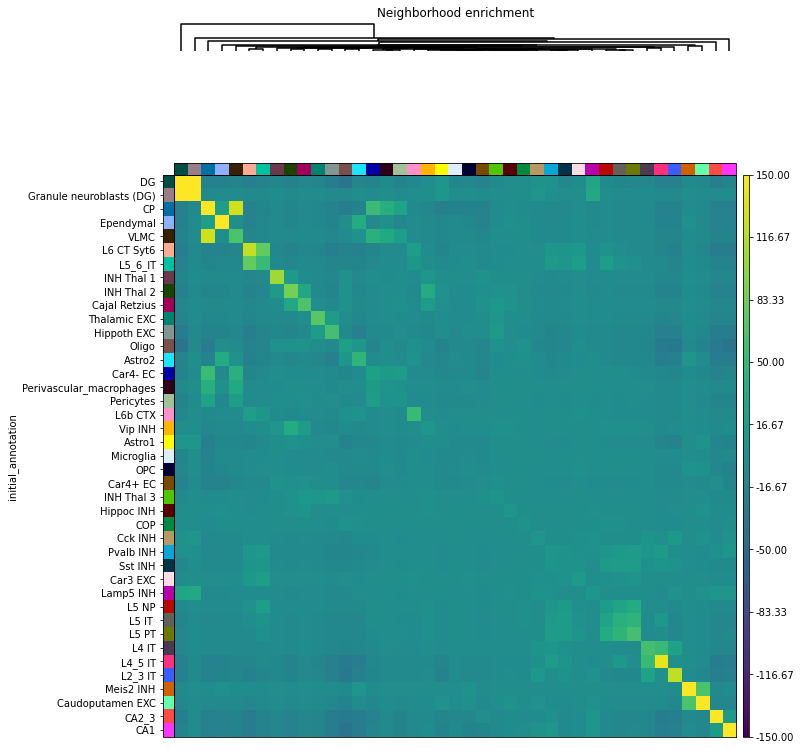

In [8]:
adatasub=ad_sp_concat
adatasub.obs['initial_annotation']=adatasub.obs['initial_annotation'].astype('category')
sq.gr.nhood_enrichment(adatasub, cluster_key="initial_annotation")
sq.pl.nhood_enrichment(adatasub, cluster_key="initial_annotation",vmax=150,vmin=-150,figsize=(10,10),method='average',cmap='viridis',show=False)
plt.savefig('../../figures/architecture_exploration_mscoronal/global_nhood_50um_viridis_allcelltypes.pdf')

Using this type of analysis, we can find colocalizing clusters (the ones with higher values). The higher the values are, the more enriched a cluster is next to a second cluster. This plot typically gives very high values for a pair of clusters and much lower values, but still interesting, for others, so it's important to play with the "vmax" parameter of the pl function and reduce the maximum value we can visualize to highlight differences between other clusters

# Interaction matrix

Squidpy provides other descriptive statistics of the spatial graph. For instance, the interaction matrix, which counts the number of edges that each cluster share with all the others. This score can be computed with the function squidpy.gr.interaction_matrix(). We can visualize the results with squidpy.pl.interaction_matrix()

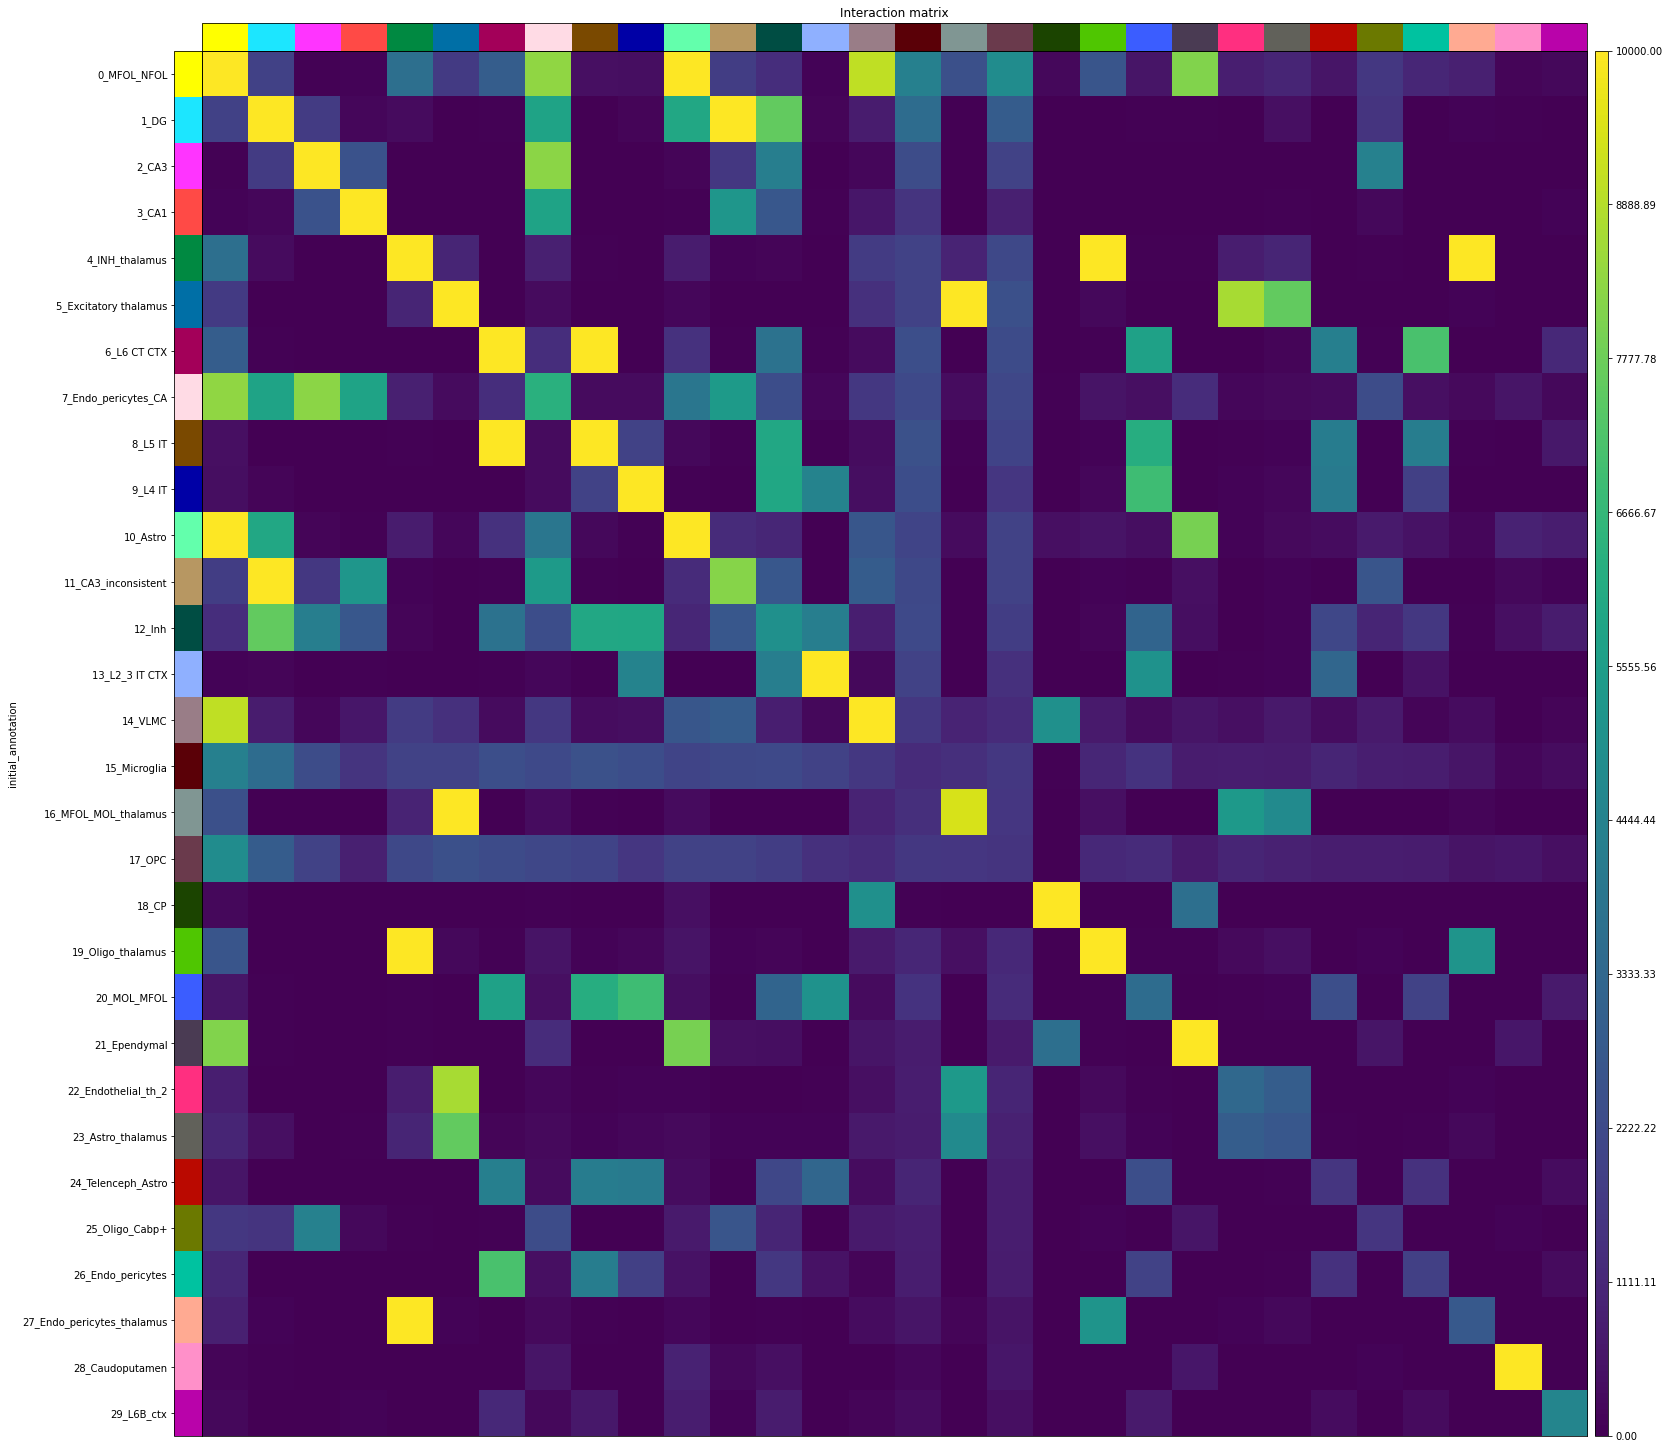

In [8]:
sq.gr.interaction_matrix(adatasub, cluster_key="initial_annotation")
sq.pl.interaction_matrix(adatasub, cluster_key="initial_annotation",vmax=10000,show=False)
plt.savefig('../../figures/architecture_exploration_mscoronal/interaction_matrix_50um_viridis_allcelltypes.pdf')

# Co-occurence of clusters

In addition to the neighbor enrichment score, we can visualize cluster co-occurrence in spatial dimensions. This is a similar analysis of the one presented above, yet it does not operate on the connectivity matrix, but on the original spatial coordinates. The co-occurrence score is the conditional probability of observing a cluster  conditioned on the presence of a cluster in the radius size of interest. The score is computed across increasing radii size around each cell in the tissue.

We can compute this score with squidpy.gr.co_occurrence() and set the cluster annotation for the conditional probability with the argument clusters. Then, we visualize the results with squidpy.pl.co_occurrence().

It can take a while to run the graph, so it's interesting to separate sq.gr.co_occurence() from sq.pl.co_occurrence() in two different chunks of code and just run the plot if we want to change anything

In [ ]:
sq.gr.co_occurrence(adatasub, cluster_key="initial_annotation",n_splits=1)

  0%|                                                                                               | 0/1 [00:00<?, ?/s]

In [ ]:
print('a')

We plot how neiborhood enrichement change in depending on the distance used. We specify our key, so the variable that contains our cell types, together with the cluster that we use as a reference for calculating the enrichement from.

In [ ]:
cluster_assessed="1_DG"
sq.pl.co_occurrence(
    adata,
    cluster_key="initial_annotation",
    clusters=cluster_assessed,
    figsize=(10, 5),show=False)
plt.savefig('../../figures/architecture_exploration_mscoronal/co_occurence_'+cluster_assessed+'.pdf')

# Properties of the spatial graph

Similar to the previous analysis, we can investigate properties of the spatial graph by computing different network centralities:

degree_centrality.

average_clustering.

closeness_centrality.

Squidpy provides a convenient function for all of them: squidpy.gr.centrality_scores() and squidpy.pl.centrality_scores() for visualization.

In [9]:
sq.gr.centrality_scores(adatasub,
    cluster_key="initial_annotation")


ERROR: Unable to fetch palette, reason: 'initial_annotation_colors'. Using `None`.


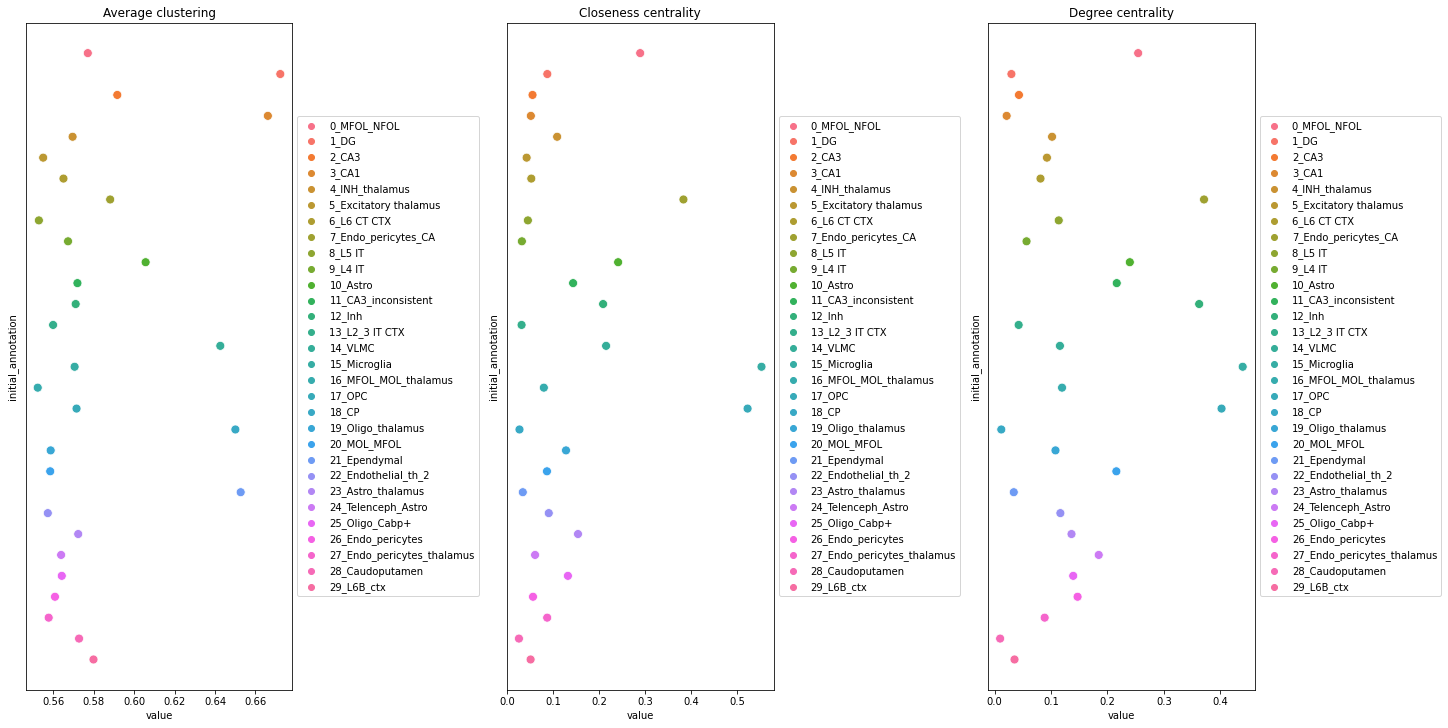

In [14]:
sq.pl.centrality_scores(adatasub, cluster_key="initial_annotation", figsize=(20, 10), s=80)#,show=False)
plt.savefig('../../figures/architecture_exploration_mscoronal/centrality_scores.pdf')

A summary of what the statistics meaning is:

-’average_clustering’ - measure of the degree to which nodes cluster together.
-’closeness_centrality’ - measure of how close the group is to other nodes.
-’degree_centrality’ - fraction of non-group members connected to group members.

More information can be found in this publication: https://www.biorxiv.org/content/10.1101/2020.02.17.947416v3

# Graph autocorrelation

With Squidpy we can investigate spatial variability of gene expression. squidpy.gr.spatial_autocorr() conveniently wraps two spatial autocorrelation statistics: Moran’s I and Geary’s C*. They provide a score on the degree of spatial variability of gene expression. The statistic as well as the p-value are computed for each gene, and FDR correction is performed. For the purpose of this tutorial, let’s compute the Moran’s I score. See Compute Moran’s I score for more details

In [9]:
sq.gr.spatial_autocorr(adatasub, mode="moran")
adatasub.uns["moranI"].head(10)

,I,pval_norm,var_norm,pval_norm_fdr_bh
Neurod6,0.571067,0.0,0.000005,0.0
Spag16,0.518762,0.0,0.000005,0.0
Slc17a7,0.481708,0.0,0.000005,0.0
Slc13a4,0.448854,0.0,0.000005,0.0
Cpne6,0.438659,0.0,0.000005,0.0
Prdm8,0.422611,0.0,0.000005,0.0
Igf2,0.417545,0.0,0.000005,0.0
2010300C02Rik,0.416017,0.0,0.000005,0.0
Calb1,0.411853,0.0,0.000005,0.0
Nrn1,0.396846,0.0,0.000005,0.0


In [10]:
adatasub.uns["moranI"].to_csv('../../figures/tables/moranI_nuclei_rep1.csv')

In [11]:
sq.gr.spatial_autocorr(adatasub, mode="geary")
adatasub.uns["gearyC"].head(10)

,C,pval_norm,var_norm,pval_norm_fdr_bh
Neurod6,0.434174,0.0,0.000005,0.0
Spag16,0.481519,0.0,0.000005,0.0
Slc17a7,0.519650,0.0,0.000005,0.0
Slc13a4,0.553869,0.0,0.000005,0.0
Cpne6,0.565397,0.0,0.000005,0.0
Igf2,0.583638,0.0,0.000005,0.0
Prdm8,0.585829,0.0,0.000005,0.0
2010300C02Rik,0.586452,0.0,0.000005,0.0
Calb1,0.593250,0.0,0.000005,0.0
Nrn1,0.604120,0.0,0.000005,0.0


In [12]:
adatasub.uns["gearyC"].to_csv('../../figures/tables/gearyC_nuclei_rep1.csv')

# Spatial organization of cell types (Ripley's K)

In addition to the neighbor enrichment score, we can further investigate spatial organization of cell types in tissue by means of the Ripley’s statistics. Ripley’s statistics allow analyst to evaluate whether a discrete annotation (e.g. cell-type) appears to be clustered, dispersed or randomly distributed on the area of interest. In Squidpy, we implement three closely related Ripley’s statistics, that can be easily computed with squidpy.gr.ripley(). Here, we’ll showcase the Ripley’s L statistic, which is a variance-stabilized version of the Ripley’s K statistics. We’ll visualize the results with squidpy.pl.ripley(). Check Compute Ripley’s statistics for more details.



In [26]:
adatasub

AnnData object with n_obs × n_vars = 232484 × 48
    obs: 'GABRG2', 'CCDC153', 'MYL9', 'GPC3', 'TMEM212', 'BCAS1', 'PdHIST1H3B Mut_B2DO', 'X', 'Y', 'Cell_ID', 'Y_IF', 'X_IF', 'mean_IF', 'IF_Cell_ID', 'name', 'AC_like', 'Cycling', 'MES_like', 'OC_like', 'OPC_like', 'total_counts', 'n_genes', 'leiden', 'sample', 'batch', 'PDCD1', 'FCER1G', 'MEST', 'age', 'loc'
    obsm: 'spatial'

ERROR: Unable to fetch palette, reason: 'initial_annotation_colors'. Using `None`.


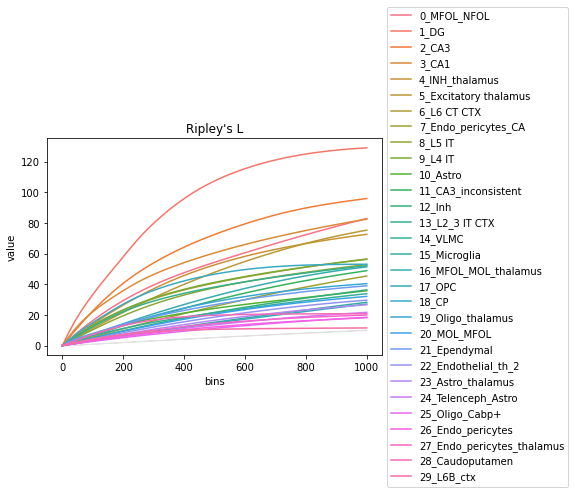

In [21]:
mode = "L"
sq.gr.ripley(adatasub, cluster_key="initial_annotation", mode=mode, max_dist=1000)
sq.pl.ripley(adatasub, cluster_key="initial_annotation", mode=mode)